# M5 accuracy competition - Benchmarking study

The M5 competition focuses on predicting the unit sales of various products sold at Walmart. This dataset contains both sales data 
and additional features such as price and event information.
The data features sales of products in different stores, different states and different product categories.
For a detailed analysis of the competition please take a look at the paper “M5 accuracy competition: Results, findings, and conclusions”. https://doi.org/10.1016/j.ijforecast.2021.11.013


In [ ]:
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# hide warnings
warnings.filterwarnings("ignore")

the `load_m5` function loads the preprocessed M5 dataset
- if the `extract_path` is None, the current is directory is used to download the dataset 

In [ ]:
from sktime.datasets._single_problem_loaders import load_m5

dataset = load_m5(extract_path="D:/datasets", include_events=True)
with open("dataset_with_events.pkl", "wb") as file:
    pickle.dump(dataset, file)
    print("Dataset Saved")

We use a pickle file to save the DataFrame because it allows us to serialize the DataFrame, preserving its exact structure, data types, and content. This makes it easy to reload the DataFrame later without needing to reprocess or reformat the data. Pickle is particularly useful when working with complex data structures and ensures faster loading compared to other formats like CSV.

In [ ]:
with open("dataset_with_events.pkl", "rb") as file:
    data = pickle.load(file)
    print("Dataset Loaded")

Dataset Loaded


## Feature Engineering
Feature engineering is a crucial step in improving model performance. Here, we will create several new features:
- *Lag Features*: Using past values of the time series (e.g., sales data from previous days).
- *Rolling Mean*: Calculating the moving average of sales over different time windows.
- *Expanding Mean*: Calculating the expanding mean, which is the average of all sales up to a given point in time.
- *Categorical Feature Encoding*: Converting categorical variables such as event types into numeric codes for machine learning models.

### Adding Features like `is_christmas`, `is_high_sale_day`, and `is_high_sale_month`

These features indicate specific time-related events or patterns, such as holidays or periods of high sales. For example, `is_christmas` identifies if a date is Christmas, while `is_high_sale_day` and `is_high_sale_month` flag days or months with historically higher sales. These features help the model account for seasonality and special events that impact sales.

In [ ]:
data["sell_price"] = data["sell_price"].fillna(0)  # fills all the NaN values as zeros

f = lambda x: 1 if x == 7 or x == 1 or x == 2 else 0
data["is_high_sale_day"] = data["wday"].map(f)

f = lambda x: 1 if x == 2 or x == 3 or x == 4 or x == 5 else 0
data["is_high_sale_months"] = data["month"].map(f)

f = lambda x: 1 if x == "Christmas" else 0
data["is_christmas"] = data["event_name_1"].map(f)

### Adding lag features
Lag features represent past values of the target variable at specific time intervals (lags). These features help the model capture temporal dependencies by providing historical data points for better forecasting accuracy.

In [ ]:
from sktime.transformations.series.lag import Lag

lags = [1, 7, 14, 21, 28]
lag_transformer = Lag(lags=lags)
# Apply the lag transformation
lag_df = lag_transformer.fit_transform(data[["sales"]])
lag_df = lag_df.fillna(0)
for lag in lags:
    data[f"lag_{lag}"] = lag_df[f"lag_{lag}__sales"]

### Adding Window Features: `rolling_mean` and `expanding_mean`

These features summarize past values over a defined window of time. The `rolling_mean` calculates the average of the target variable over a fixed time window, moving forward with each new observation. 

The `expanding_mean` calculates the average from the start of the series up to the current observation, capturing long-term trends. Both features help smooth out short-term fluctuations and reveal underlying trends in the data.


In [ ]:
window = [7, 14, 21, 28]
for i in window:
    data["rolling_mean_" + str(i)] = data["sales"].transform(
        lambda s: s.rolling(i).mean()
    )

window = [
    "rolling_mean_7",
    "rolling_mean_14",
    "rolling_mean_21",
    "rolling_mean_28",
]
for i in window:
    data[i] = data[i].fillna(0)

# Expading mean
data["expanding_mean"] = data["sales"].transform(lambda s: s.expanding().mean())
data["expanding_mean"] = data["expanding_mean"].fillna(0)

### Converting Categorical Columns to Numeric Codes

In this step, we convert categorical columns, `event_type_1` and `event_type_2`, into numeric codes. Each unique category is assigned a numeric value, starting from 1. This helps the model understand categorical data by representing them as numerical values, which is essential for most machine learning algorithms

In [ ]:
cols_to_convert = ["event_type_1", "event_type_2"]
data[cols_to_convert] = data[cols_to_convert].apply(
    lambda x: x.astype("category").cat.codes + 1
)

Dropping the unwanted columns and saving the processed dataframe as a pickle file

In [ ]:
data = data.drop(
    ["event_name_1", "event_name_2", "wday", "month", "wm_yr_wk", "year"],
    axis=1,
)

complete feature engineering in the a function

In [ ]:
def sales_feature_engineering(data, item_names):
    """Feature Engineering of the dataset on selected item/s."""
    result = []
    for item_name in item_names:
        dataset = data[data["id"] == item_name]

        dataset["sell_price"] = dataset["sell_price"].fillna(
            0
        )  # fills all the NaN values as zeros

        f = lambda x: 1 if x == 7 or x == 1 or x == 2 else 0
        dataset["is_high_sale_day"] = dataset["wday"].map(f)

        f = lambda x: 1 if x == 2 or x == 3 or x == 4 or x == 5 else 0
        dataset["is_high_sale_months"] = dataset["month"].map(f)

        f = lambda x: 1 if x == "Christmas" else 0
        dataset["is_christmas"] = dataset["event_name_1"].map(f)

        from sktime.transformations.series.lag import Lag

        lags = [1, 7, 14, 21, 28]
        lag_transformer = Lag(lags=lags)
        # Apply the lag transformation
        lag_df = lag_transformer.fit_transform(dataset[["sales"]])
        lag_df = lag_df.fillna(0)
        for lag in lags:
            dataset[f"lag_{lag}"] = lag_df[f"lag_{lag}__sales"]

        window = [7, 14, 21, 28]
        for i in window:
            dataset["rolling_mean_" + str(i)] = dataset["sales"].transform(
                lambda s: s.rolling(i).mean()
            )

        window = [
            "rolling_mean_7",
            "rolling_mean_14",
            "rolling_mean_7",
            "rolling_mean_21",
            "rolling_mean_28",
        ]
        for i in window:
            dataset[i] = dataset[i].fillna(0)

        # Expading mean
        dataset["expanding_mean"] = dataset["sales"].transform(
            lambda s: s.expanding().mean()
        )
        dataset["expanding_mean"] = dataset["expanding_mean"].fillna(0)

        cols_to_convert = ["event_type_1", "event_type_2"]
        dataset[cols_to_convert] = dataset[cols_to_convert].apply(
            lambda x: x.astype("category").cat.codes + 1
        )

        dataset = dataset.drop(
            ["event_name_1", "event_name_2", "wday", "month", "wm_yr_wk", "year"],
            axis=1,
        )

        result.append(dataset)

    combined_data = pd.concat(result)

    return combined_data

## Forecasting with a single item
Selecting a single item from the dataset to implement the models on it.

<a id="custom-anchor"></a>
We are selecting the item based on the total sales of the item i.e, the item/s with the highest number of sales

In [ ]:
df = data.groupby("id")["sales"].sum()
df.sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: sales, Length: 30490, dtype: int64

Since the item with the highest sales is `FOODS_3_090_CA_3_validation`, we will be using it.

In [ ]:
final_data = sales_feature_engineering(
    data=data, item_names=["FOODS_3_090_CA_3_validation"]
)

Converting `id` column into cat.codes for forecasters

In [ ]:
cols = ["id"]
final_data[cols] = final_data[cols].apply(lambda x: x.astype("category").cat.codes)
final_data

id   day  sales  event_type_1  \
state_id store_id cat_id dept_id date                                          
1        3        1      3       2011-01-29  7022     1    108             0   
                                 2011-01-30  7022     2    132             0   
                                 2011-01-31  7022     3    102             0   
                                 2011-02-01  7022     4    120             0   
                                 2011-02-02  7022     5    106             0   
...                                           ...   ...    ...           ...   
                                 2016-04-20  7022  1909     88             0   
                                 2016-04-21  7022  1910     77             0   
                                 2016-04-22  7022  1911    141             0   
                                 2016-04-23  7022  1912    139             0   
                                 2016-04-24  7022  1913    130             0   

                                             event_type_2  sell_price  \
state_id store_id cat_id dept_id date                                   
1        3        1      3       2011-01-29             0    1.250000   
                                 2011-01-30             0    1.250000   
                                 2011-01-31             0    1.250000   
                                 2011-02-01             0    1.250000   
                                 2011-02-02             0    1.250000   
...                                                   ...         ...   
                                 2016-04-20             0    1.599609   
                                 2016-04-21             0    1.599609   
                                 2016-04-22             0    1.599609   
                                 2016-04-23             0    1.599609   
                                 2016-04-24             0    1.599609   

                                             is_high_sale_day  \
state_id store_id cat_id dept_id date                           
1        3        1      3       2011-01-29                 1   
                                 2011-01-30                 1   
                                 2011-01-31                 0   
                                 2011-02-01                 0   
                                 2011-02-02                 0   
...                                                       ...   
                                 2016-04-20                 0   
                                 2016-04-21                 0   
                                 2016-04-22                 1   
                                 2016-04-23                 1   
                                 2016-04-24                 1   

                                             is_high_sale_months  \
state_id store_id cat_id dept_id date                              
1        3        1      3       2011-01-29                    0   
                                 2011-01-30                    0   
                                 2011-01-31                    0   
                                 2011-02-01                    1   
                                 2011-02-02                    1   
...                                                          ...   
                                 2016-04-20                    1   
                                 2016-04-21                    1   
                                 2016-04-22                    1   
                                 2016-04-23                    1   
                                 2016-04-24                    1   

                                             is_christmas  lag_1  lag_7  \
state_id store_id cat_id dept_id date                                     
1        3        1      3       2011-01-29             0    0.0    0.0   
                                 2011-01-30             0  108.0    0.0   
                         

### Splitting into Endogenous and Exogenous Data

The endogenous data contains the target variable we want to predict, which is influenced by internal factors within the dataset. On the other hand, the exogenous data consists of external features that may affect the target variable but are not themselves being predicted.


In [ ]:
X = final_data.drop(columns=["day", "sales"], axis=1)
y = final_data[["sales"]]

### Train and Test split
- Splitting the data into train and test datasets to fit and run the models
- The `load` function returns the y and X dataframes which will be used in the `ForecastingBenchmark` 

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)


def load():
    """Return y and X dataframes."""
    return (y, X)

### Error terms
RMSE *(Root Mean Squared Error)* is a metric that measures the average magnitude of error in predictions. It’s the square root of the average squared differences between actual and predicted values. A lower RMSE indicates better model accuracy.

In [ ]:
from sktime.performance_metrics.forecasting import MeanSquaredError

rmse = MeanSquaredError(square_root=True)

Since the data is hierarchical, we define a helper function `plot_pred` which deals with hierarchy levels and plots the prediction with test data

In [ ]:
from sktime.utils.plotting import plot_series


def re_index(df):
    """Reindex the dataframe inorder to plot the data."""
    drop_cols = ["state_id", "store_id", "cat_id", "dept_id"]
    return df.reset_index().set_index("date").drop(drop_cols, axis=1)


def plot_pred(y_test, y_pred):
    """Plot y_test with y_pred of single item."""
    y_test_plot = re_index(y_test)
    y_pred_plot = re_index(y_pred)

    plot_series(y_test_plot, y_pred_plot, labels=["test", "prediction"])

#### Model Definitions

We are using RandomForesterRegressor and LGBMRegressor here:
- *RandomForestRegressor*: An ensemble method that builds multiple decision trees to make predictions.
- *LightGBM*: A gradient boosting framework that is faster and more efficient on large datasets.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction

We use `make_reduction` from sktime to create a reduction strategy for transforming time series forecasting tasks into supervised learning problems. This function allows us to efficiently handle complex forecasting tasks by converting time series data into a format suitable for various machine learning models. By using `make_reduction`, we can specify the base estimator and the type of reduction (e.g., using a regressor for forecasting), making it easier to implement and evaluate different forecasting strategies.

In [ ]:
regressor_rf = RandomForestRegressor(n_estimators=100)
forecaster_rf = make_reduction(regressor_rf, strategy="recursive", pooling="global")

regressor_lgbm = LGBMRegressor(objective="poisson", verbose=-1)
forecaster_lgbm = make_reduction(regressor_lgbm, strategy="recursive", pooling="global")

using RandomForestRegressor

In [ ]:
forecaster_rf.fit(y_train, X=X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                     pooling='global')

34.21073413815317

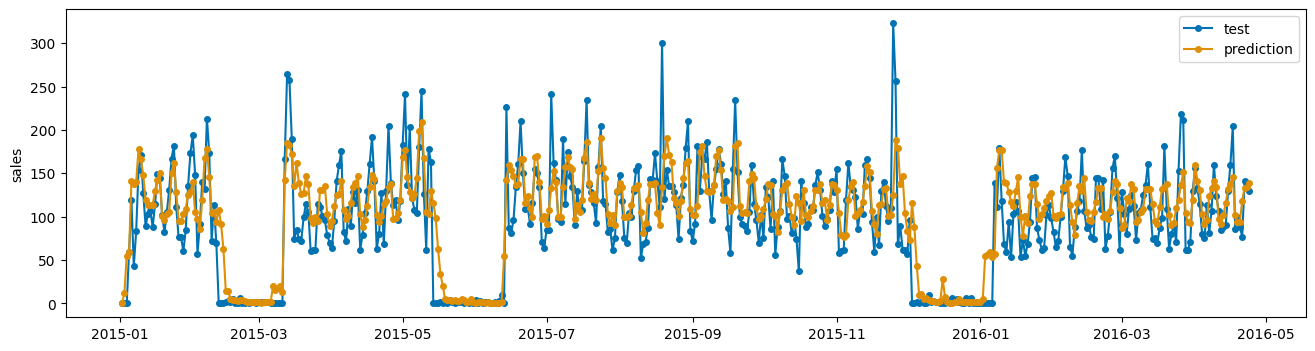

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = forecaster_rf.predict(fh=fh, X=X_test)
plot_pred(y_test, y_pred)
rmse(y_test, y_pred)

#### ForecastingBenchmark 
* The ForecastingBenchmark in sktime allows you to systematically test and compare multiple forecasting models 
on the same dataset. 
* We can use this framework to evaluate multiple models, 
providing insights into which models work best for our specific dataset.

* `ExpandingWindowSplitter` - creates training and test splits where the training data increases over time, while the test data size stays the same. This helps evaluate model performance as more data becomes available.

In [ ]:
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import ExpandingWindowSplitter

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

benchmark = ForecastingBenchmark()
fh = list(range(1, len(y_test) + 1))
benchmark.add_estimator(NaiveForecaster(strategy="mean"))
benchmark.add_estimator(ExponentialSmoothing())
benchmark.add_estimator(AutoETS(auto=True))

benchmark.add_task(
    dataset_loader=load,
    cv_splitter=cv,
    scorers=[MeanSquaredError(square_root=True)],
    task_id="M5_rmse",
)

In [ ]:
benchmark.run(output_file="results.txt")

,validation_id,model_id,runtime_secs,MeanSquaredError_fold_0_test,MeanSquaredError_fold_1_test,MeanSquaredError_fold_2_test,MeanSquaredError_fold_3_test,MeanSquaredError_fold_4_test,MeanSquaredError_fold_5_test,MeanSquaredError_fold_6_test,...,MeanSquaredError_fold_69_test,MeanSquaredError_fold_70_test,MeanSquaredError_fold_71_test,MeanSquaredError_fold_72_test,MeanSquaredError_fold_73_test,MeanSquaredError_fold_74_test,MeanSquaredError_fold_75_test,MeanSquaredError_fold_76_test,MeanSquaredError_mean,MeanSquaredError_std
0,M5_rmse,AutoETS,10.588218,1.469464e-40,1.079853e-60,7.932421e-81,5.834191e-101,4.291572e-121,3.148760e-141,2.320628e-161,...,45.446528,74.689974,140.355491,61.850706,41.696969,49.555124,37.982938,66.358402,76.952020,55.445196
1,M5_rmse,ExponentialSmoothing,6.883482,1.471769e-40,1.082392e-60,7.960304e-81,5.854295e-101,4.305460e-121,3.166391e-141,2.331249e-161,...,45.435216,74.677287,140.378058,61.851228,41.690287,49.545336,37.982878,66.329927,76.946488,55.434611
2,M5_rmse,NaiveForecaster,5.769650,2.418333e+01,1.727381e+01,1.343519e+01,1.099242e+01,9.301282e+00,8.061111e+00,7.112745e+00,...,43.214127,58.835011,122.454883,112.049969,47.613270,42.412938,44.205132,43.978858,91.052647,65.049006


We use the `ForecastingGridSearchCV` to evaluate and get best fit parameters for the LGBM regressor

In [ ]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

params_grid = {
    "learning_rate": [0.4, 0.5, 1],
    "n_estimators": [75, 100],
}

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

gscv_lgbm = ForecastingGridSearchCV(
    forecaster_lgbm,
    cv=cv,
    param_grid=params_grid,
)

gscv_lgbm.fit(y=y_train, X=X_train)
gscv_lgbm.best_params_

{'learning_rate': 1, 'n_estimators': 75}

84.69179047401937

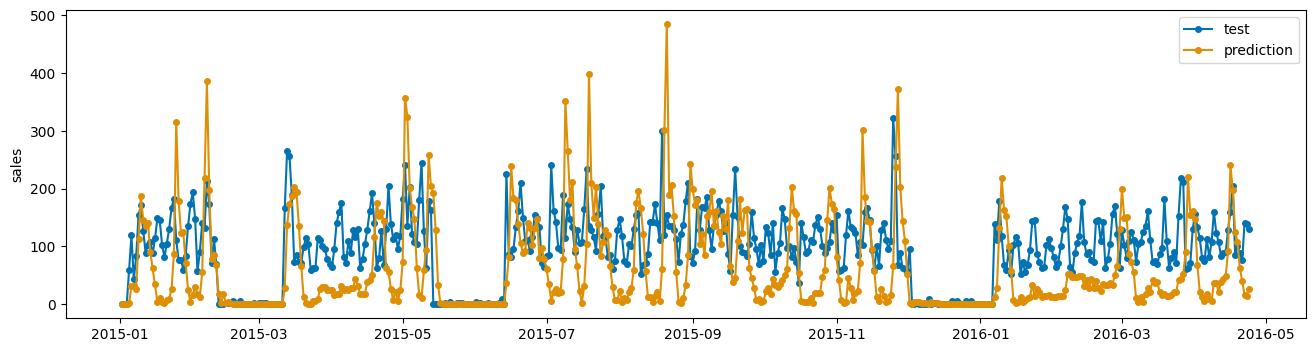

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = gscv_lgbm.predict(X=X_test, fh=fh)
plot_pred(y_test, y_pred)
rmse(y_test.round(), y_pred.round())

## Forecasting with multiple items using `ReconcilerForecaster`

In time series forecasting, hierarchical reconciliation is a method used to ensure that forecasts at different levels of a hierarchy are consistent. 

For example, in a product sales hierarchy, forecasts for individual products should sum to match the total forecast for the overall category.

The process involves two main steps:
- *Base Forecast Generation*: Forecasts are first generated independently for each time series at different levels of the hierarchy. These can be generated using any standard forecaster.
- *Reconciliation Step*: The base forecasts are then adjusted (reconciled) so that they add up correctly across the hierarchy. This ensures that the sum of forecasts at lower levels aligns with the forecasts at higher levels in the hierarchy.

Reconciliation not only ensures consistency but can also improve the overall accuracy of the forecasts by leveraging the relationships between different levels in the hierarchy.


In [ ]:
from sktime.forecasting.reconcile import ReconcilerForecaster

Selecting the three highest sold items from the data to run the reconciler forecaster

In [ ]:
df = data.groupby("id")["sales"].sum()
df.sort_values(ascending=False)[:3]

id
FOODS_3_090_CA_3_validation    250502
FOODS_3_586_TX_2_validation    192835
FOODS_3_586_TX_3_validation    150122
Name: sales, dtype: int64

In [ ]:
hier_data = sales_feature_engineering(
    data=data,
    item_names=[
        "FOODS_3_090_CA_3_validation",
        "FOODS_3_586_TX_2_validation",
        "FOODS_3_586_TX_3_validation",
    ],
)

hier_data.set_index("id", append=True, inplace=True)
hier_data = hier_data.reorder_levels(
    ["state_id", "store_id", "cat_id", "dept_id", "id", "date"]
)
hier_data.sort_index(inplace=True)

hier_data

day  \
state_id store_id cat_id dept_id id                          date               
1        3        1      3       FOODS_3_090_CA_3_validation 2011-01-29     1   
                                                             2011-01-30     2   
                                                             2011-01-31     3   
                                                             2011-02-01     4   
                                                             2011-02-02     5   
...                                                                       ...   
2        7        1      3       FOODS_3_586_TX_3_validation 2016-04-20  1909   
                                                             2016-04-21  1910   
                                                             2016-04-22  1911   
                                                             2016-04-23  1912   
                                                             2016-04-24  1913   

                                                                         sales  \
state_id store_id cat_id dept_id id                          date                
1        3        1      3       FOODS_3_090_CA_3_validation 2011-01-29    108   
                                                             2011-01-30    132   
                                                             2011-01-31    102   
                                                             2011-02-01    120   
                                                             2011-02-02    106   
...                                                                        ...   
2        7        1      3       FOODS_3_586_TX_3_validation 2016-04-20     60   
                                                             2016-04-21     55   
                                                             2016-04-22     55   
                                                             2016-04-23     66   
                                                             2016-04-24     47   

                                                                         event_type_1  \
state_id store_id cat_id dept_id id                          date                       
1        3        1      3       FOODS_3_090_CA_3_validation 2011-01-29             0   
                                                             2011-01-30             0   
                                                             2011-01-31             0   
                                                             2011-02-01             0   
                                                             2011-02-02             0   
...                                                                               ...   
2        7        1      3       FOODS_3_586_TX_3_validation 2016-04-20             0   
                                                             2016-04-21             0   
                                                             2016-04-22             0   
                                                             2016-04-23             0   
                                                             2016-04-24             0   

                                                                         event_type_2  \
state_id store_id cat_id dept_id id                          date                       
1        3        1      3       FOODS_3_090_CA_3_validation 2011-01-29             0   
                                                             2011-01-30             0   
                                                             2011-01-31             0   
                                                             2011-02-01             0   
                                                             2011-02-02             0   
...                                                                               ...   
2        7        1      3       FOODS_3_586_TX_3_validation 2016-04-20            

Splitting into Endogenous and Exogenous Data, and Creating Train and Test Sets

In [ ]:
from sktime.split.temporal_train_test_split import temporal_train_test_split

X = hier_data.drop(columns=["day", "sales"], axis=1)
y = hier_data[["sales"]]

# Train and Test split
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

Plotting the items on a graph to visualize 

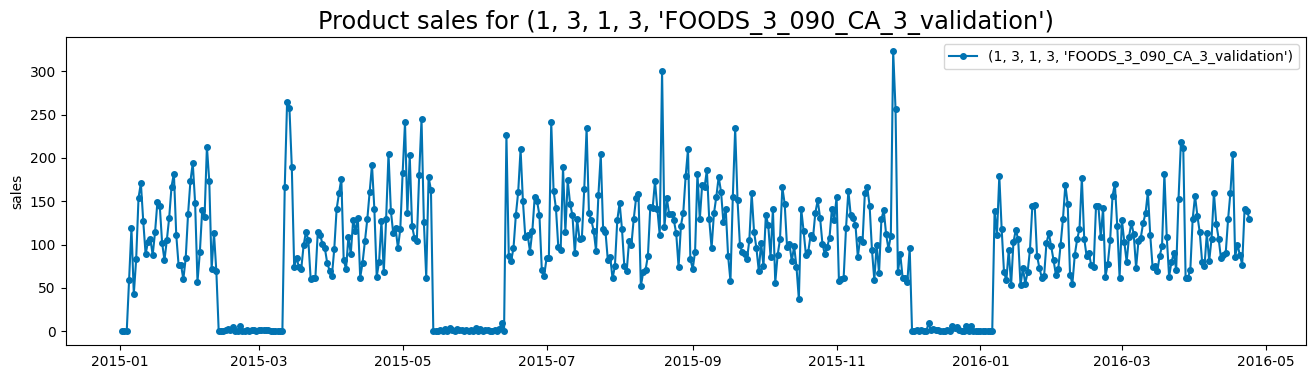

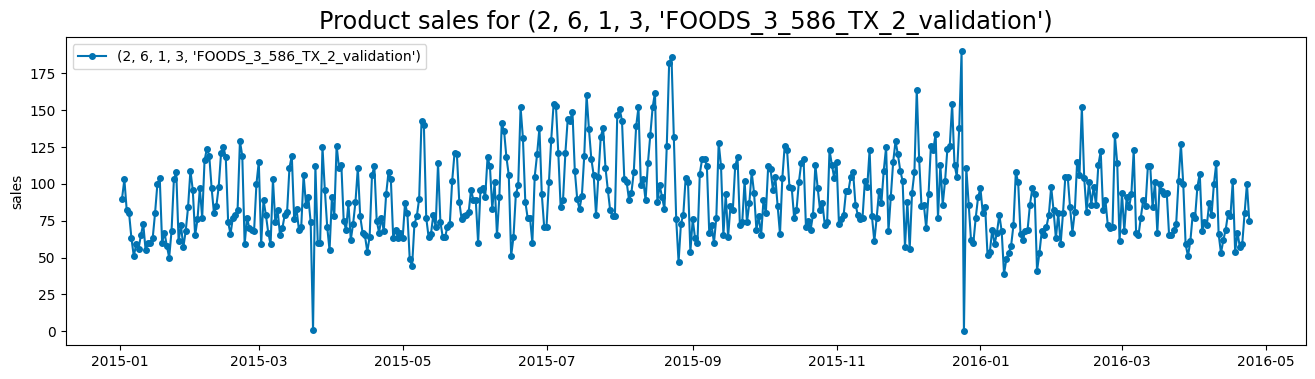

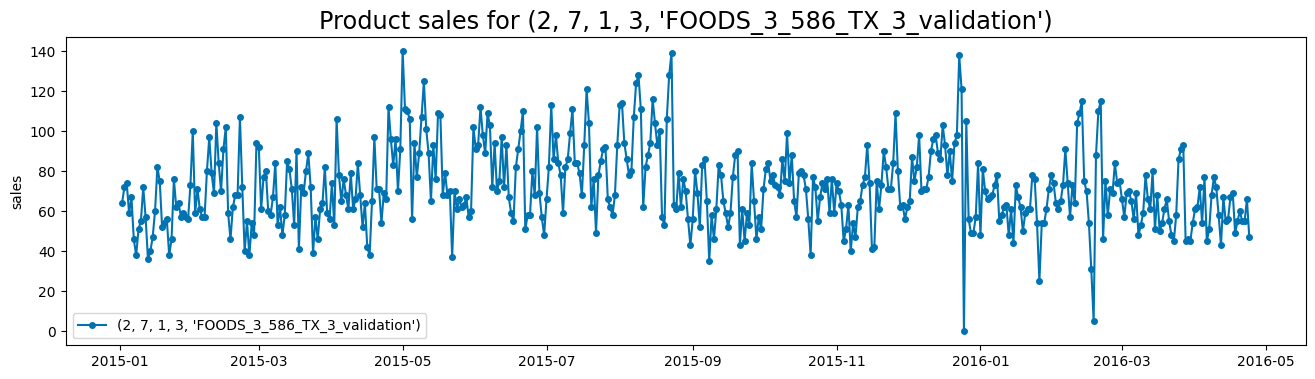

In [ ]:
product_index = y_test.droplevel(-1).index.unique()
for idx in product_index:
    fig, ax = plot_series(
        y_test.loc[idx], labels=[str(idx)], title=f"Product sales for {idx}"
    )
    plt.show()

passing LGBMRegressor to the reconciler foreacaster

In [ ]:
# ReconcilerForecaster
regressor = LGBMRegressor(
    n_estimators=150, learning_rate=0.8, objective="regression_l1", verbose=-1
)
forecaster = make_reduction(regressor, strategy="recursive", pooling="global")

reconciler = ReconcilerForecaster(forecaster, method="ols", return_totals=False)
reconciler.fit(y=y_train, X=X_train)

ReconcilerForecaster(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.8, n_estimators=150, objective='regression_l1',
              verbose=-1),
                                                                     pooling='global'),
                     method='ols', return_totals=False)

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = reconciler.predict(X=X_test, fh=fh)
y_pred = y_pred.loc[y_pred.index.get_level_values("date") <= "2016-04-24"]

In [ ]:
# removing the dunder levels returned from the recocniler forecaster
n = y_pred.index.get_slice_bound(label="__total", side="left")
if len(y_pred[:n]) == 0:
    y_pred = y_pred[n:]
else:
    y_pred = y_pred[:n]
level_values = y_pred.index.get_level_values(-2)
y_pred = y_pred[~(level_values == "__total")]

In [ ]:
y_pred

sales
state_id store_id cat_id dept_id id                          date                 
1        3        1      3       FOODS_3_090_CA_3_validation 2015-01-02  -0.950668
                                                             2015-01-03   2.520588
                                                             2015-01-04  -0.710491
                                                             2015-01-05  31.103846
                                                             2015-01-06  45.385232
...                                                                            ...
2        7        1      3       FOODS_3_586_TX_3_validation 2016-04-20  60.103112
                                                             2016-04-21  45.148580
                                                             2016-04-22  67.107776
                                                             2016-04-23  67.827505
                                                             2016-04-24  77.910206

[1437 rows x 1 columns]

Plotting the test data and prediction data of the three items 

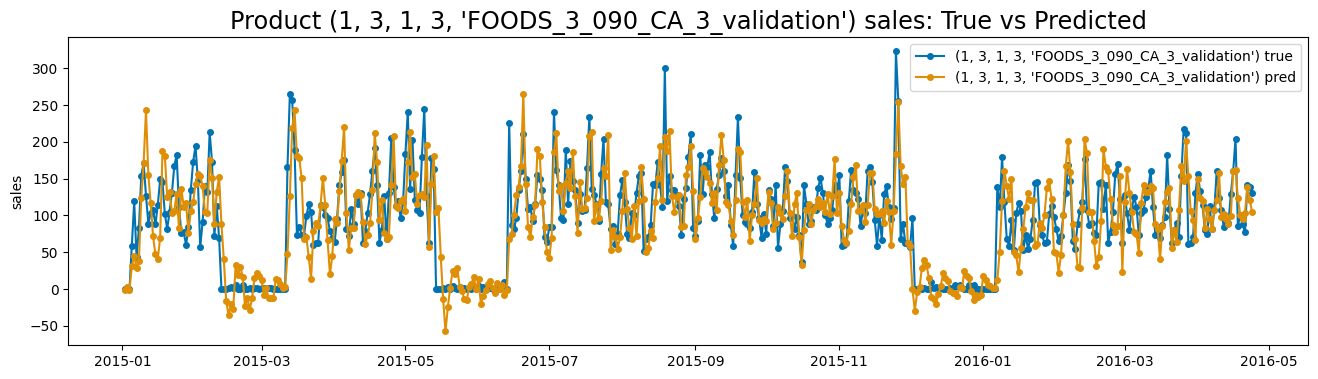

RMSE: 40.04188722962306


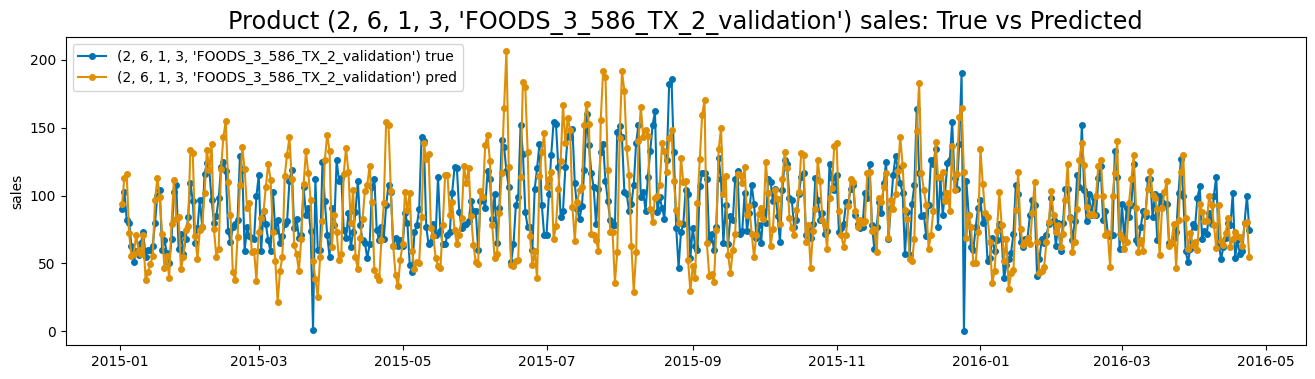

RMSE: 30.65249202131659


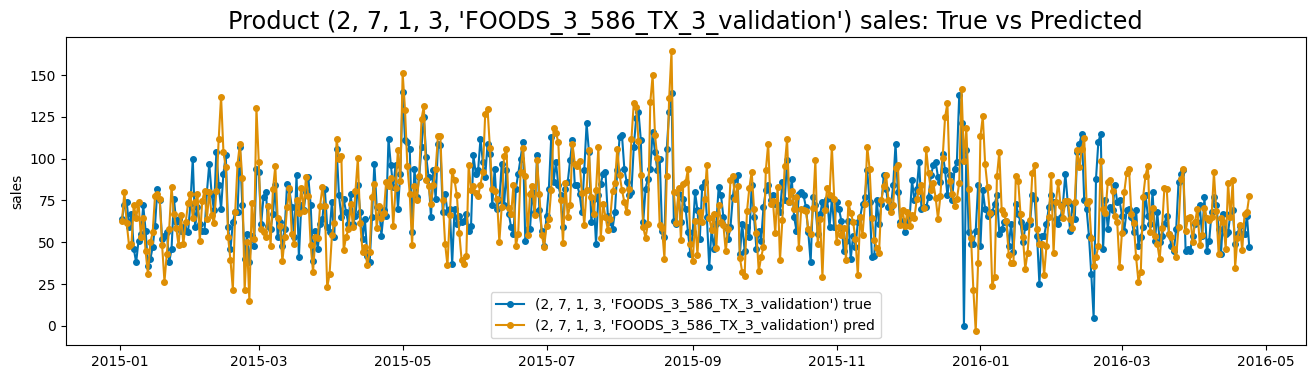

RMSE: 19.964306942562292


In [ ]:
for idx in product_index:
    fig, ax = plot_series(
        y_test.loc[idx],
        y_pred.loc[idx],
        labels=[f"{idx} true", f"{idx} pred"],
        title=f"Product {idx} sales: True vs Predicted",
    )
    plt.show()  # Display each plot separately
    y_true = y_test.loc[idx]
    y_prediction = y_pred.loc[idx]
    print(f"RMSE: {rmse(y_true, y_prediction)}")

## Probabilistic Models on the dataset

### Conformal Intervals for Probabilistic Forecasting 

Conformal intervals offer a way to quantify the uncertainty in forecasts, 
providing a range within which the future sales are expected to lie with a given probability.

Selecting an item randomly from the list of high sale items


In [ ]:
df = data.groupby("id")["sales"].sum()
df.sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: sales, Length: 30490, dtype: int64

In [ ]:
prob_data = sales_feature_engineering(
    data=data, item_names=["FOODS_3_586_TX_2_validation"]
)
prob_data[cols] = prob_data[cols].apply(lambda x: x.astype("category").cat.codes)

Splitting the data into endogeneous and exogeneous data and into train and test splits

In [ ]:
X = prob_data.drop(columns=["day", "sales"], axis=1)
y = prob_data[["sales"]]

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)

In [ ]:
# making subset of data

_X_train = X_train[-300:]
_X_test = X_test[:100]
_y_train = y_train[-300:]
_y_test = y_test[:100]

In [ ]:
from sktime.forecasting.conformal import ConformalIntervals

conf_model = ConformalIntervals(
    forecaster_lgbm,
    method="conformal",
    initial_window=60,
    verbose=True,
    sample_frac=0.001,
    n_jobs=-1,
)

In [ ]:
fh = list(range(1, len(_y_test) + 1))
conf_model.fit(y=_y_train, X=_X_train)

ConformalIntervals(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(objective='poisson', verbose=-1),
                                                                   pooling='global'),
                   initial_window=60, method='conformal', n_jobs=-1,
                   sample_frac=0.001, verbose=True)

A `0.95` coverage means that *95%* of the time, the confidence intervals generated from repeated samples will contain the true population parameter. In other words, the method used to create the intervals has a 95% success rate in capturing the true value across many samples.

In [ ]:
y_pred_ints = conf_model.predict_interval(fh=fh, X=_X_test, coverage=0.95)
y_pred = conf_model.predict(fh=fh, X=_X_test)
y_pred_ints

sales            
                                                  0.95            
                                                 lower       upper
state_id store_id cat_id dept_id date                             
2        6        1      3       2015-01-02   49.44501  166.021798
                                 2015-01-03  47.060763  168.580097
                                 2015-01-04  48.388032  164.287414
                                 2015-01-05  27.016379  143.157823
                                 2015-01-06  19.222338  133.997464
...                                                ...         ...
                                 2015-04-07   33.64473  114.947451
                                 2015-04-08  32.020211  117.262591
                                 2015-04-09  36.635579  131.743667
                                 2015-04-10  49.274214  132.640771
                                 2015-04-11  52.427063  137.595636

[100 rows x 2 columns]

In [ ]:
def plot_ints(y_test, y_pred_ints, cov, y_pred=None):
    """Plot the intervals."""
    y_pred_ints_ = re_index(y_pred_ints)
    y_test_ = re_index(y_test)

    # Plot test vs intervals
    fig, ax1 = plot_series(
        y_test_,
        y_pred_ints_[("sales", cov, "lower")],
        y_pred_ints_[("sales", cov, "upper")],
        labels=["test", "Prediction interval", ""],
        colors=["blue", "skyblue", "skyblue"],
        title="with Test",
    )

    ax1.fill_between(
        y_test_.index,
        y_pred_ints_[("sales", cov, "lower")],
        y_pred_ints_[("sales", cov, "upper")],
        color="skyblue",
        alpha=0.2,
    )

    # Plot prediction vs intervals
    if y_pred is not None:
        y_pred_ = re_index(y_pred)
        fig, ax2 = plot_series(
            y_pred_,
            y_pred_ints_[("sales", cov, "lower")],
            y_pred_ints_[("sales", cov, "upper")],
            labels=["pred", "Prediction interval", ""],
            colors=["blue", "skyblue", "skyblue"],
            title="with Prediction",
        )

        ax2.fill_between(
            y_pred_.index,
            y_pred_ints_[("sales", cov, "lower")],
            y_pred_ints_[("sales", cov, "upper")],
            color="skyblue",
            alpha=0.2,
        )

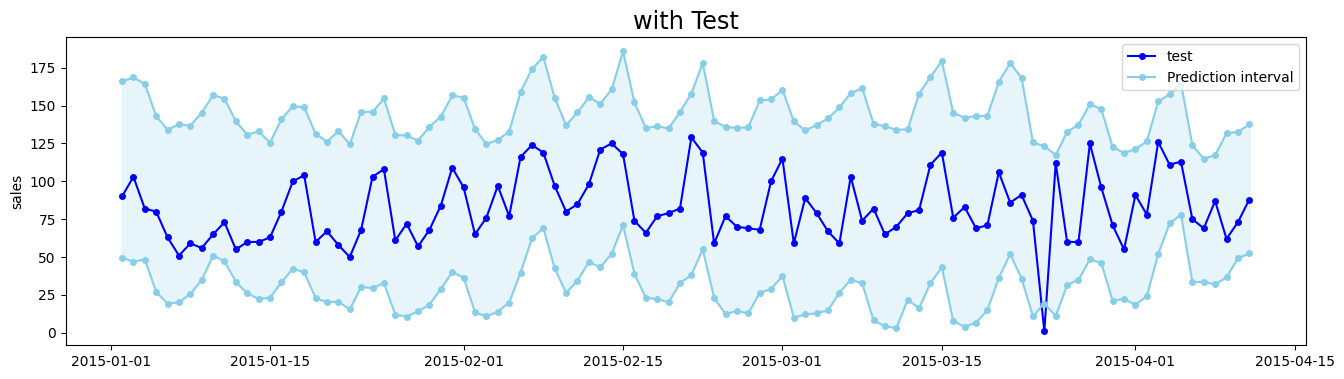

In [ ]:
plot_ints(_y_test, y_pred_ints, 0.95)

### Evaluation Metrics for Probabilistic Forecasting

For probabilistic forecasting, we use the following evaluation metrics:

**Pinball Loss**: This measures the accuracy of probabilistic predictions at specific quantiles. A lower pinball loss indicates better accuracy in quantile predictions.

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

pb_loss = PinballLoss(multioutput="uniform_average", score_average=True)
pb_loss(_y_test, y_pred_ints)

1.5158389705423039

**Interval Width**: This measures the average width of the prediction intervals, giving insights into how wide the confidence intervals are.

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import IntervalWidth

int_width = IntervalWidth(multioutput="uniform_average", score_average=True)
int_width(_y_test, y_pred_ints)

113.94351723864916

**Empirical Coverage**: This metric calculates the proportion of actual values that fall within the predicted intervals, helping us understand how well the intervals capture the true values.

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import EmpiricalCoverage

emp_cov = EmpiricalCoverage(multioutput="uniform_average", score_average=True)
emp_cov(_y_test, y_pred_ints)

0.99

We predict **quantiles** in forecasting to capture the uncertainty in the predictions, providing more information than just point estimates. `Quantile predictions` allow us to estimate the range within which future values are likely to fall, giving us different probability intervals (e.g., 10th, 50th, and 90th percentiles). This is particularly useful in real-world scenarios where we need to assess risks and make informed decisions under uncertainty. By predicting quantiles, we can better understand the distribution of possible outcomes and prepare for best-case, median-case, and worst-case scenarios.

In [ ]:
y_pred_quant = conf_model.predict_quantiles(fh=fh, X=_X_test, alpha=[0.1, 0.5, 0.9])

In [ ]:
y_pred_quant

sales                        
                                                   0.1         0.5         0.9
state_id store_id cat_id dept_id date                                         
2        6        1      3       2015-01-02  82.616277  107.916079  132.850531
                                 2015-01-03  82.788849    107.8354  132.852011
                                 2015-01-04   81.94523  106.487552  130.730215
                                 2015-01-05  59.574215     85.2261  110.599986
                                 2015-01-06  51.741201   76.682378    101.4786
...                                                ...         ...         ...
                                 2015-04-07  45.666591   74.418803  102.925591
                                 2015-04-08  46.731095   74.822888  102.551707
                                 2015-04-09  56.428687   84.448685   111.95056
                                 2015-04-10  62.071631   91.009594  119.843355
                                 2015-04-11  65.457355    95.02512  124.565344

[100 rows x 3 columns]

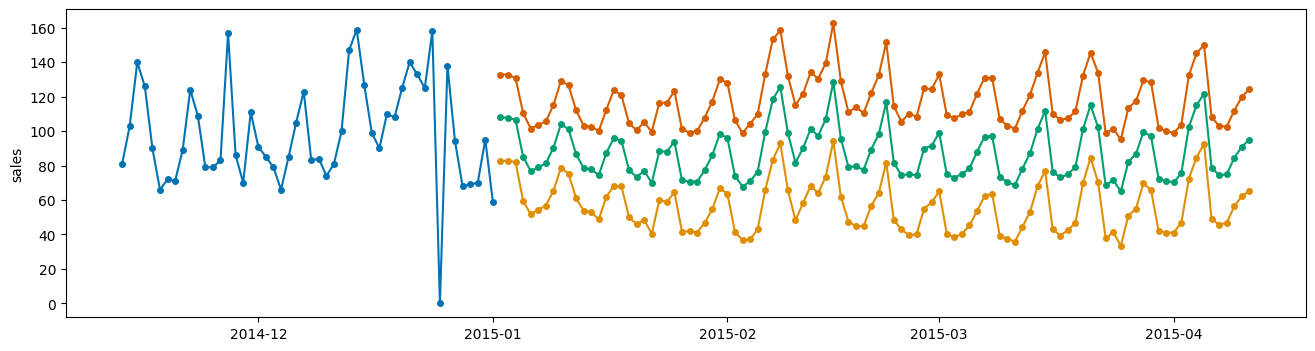

In [ ]:
_y_train_ = re_index(_y_train)
y_pred_quants = re_index(y_pred_quant)

columns = [y_pred_quants[i] for i in y_pred_quants.columns]
fig, ax = plot_series(_y_train_[-50:], *columns)